In [2]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import warnings
from IPython.display import display
import os
import sys
import kaleido
import plotly
import pandas as pd
import pickle
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas._libs.tslibs.parsing import DateParseError
import matplotlib.pyplot as plt
import seaborn as sns
#import functions.gui
from dateutil.relativedelta import relativedelta
import functions.GrangerCausality
import functions.NP_model
import functions.settings
functions.settings.init() 
import matplotlib

/Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/kaleido/_sync_server.py:11: UserWarning: 


This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.

  from .kaleido import Kaleido
/Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/lightning_fabric/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook impor

In [5]:
functions.settings.current_wd = os.getcwd()

## Parametros

In [ ]:
#Nombre del proyecto
functions.settings.project_name = 'MiPyMes E1'

#Ruta archivo inicial
RUTA_HISTORICO = '/Users/andre.rodriguez/Documents/Git/ir-ESC/Datos/PI_Hist_Por_Etapas_202503.csv'
#Columnas de fecha y sobre la que se hara la prediccion
col_fecha = 'aniomes'
col_pred = 'PI'

#Ruta VarsEco_Base
RUTA_ESC_BASE = '/Users/andre.rodriguez/Documents/Git/ir-ESC/Datos/VarsEco_Base.csv'

#Ruta VarsEco_Adverso
RUTA_ESC_ADV = '/Users/andre.rodriguez/Documents/Git/ir-ESC/Datos/VarsEco_Adverso.csv'

#Fecha de corte entrenamiento
fecha_train = '202412'

#Lista de eventos
events = [
            {
                "ds": pd.date_range(start='2020-03-01', end='2021-12-31', freq='MS'), #ajustar fecha de inicio y fin
                'covid': 1  #cambiar nombre del evento, el 1 se mantiene como valor
            },
            {
                "ds": pd.date_range(start='2024-01-01', end='2024-12-31', freq='MS'), #ajustar fecha de inicio y fin
                'cartera_banregio': 1  #cambiar nombre del evento, el 1 se mantiene como valor
            }
        ]

In [7]:
if functions.settings.project_name is not None:
    functions.settings.create_dir()
    print(functions.settings.project_name)
else:
    print("No input received.")
    sys.exit()

MiPyMes E1


## Lectura de bases

In [30]:
def read_file_to_dataframe(path):
    ext = os.path.splitext(path)[1].lower()
    if ext == ".csv":
        return pd.read_csv(path)
    elif ext in [".xls", ".xlsx"]:
        return pd.read_excel(path)
    else:
        raise ValueError(f"Unsupported file type: {ext}")

In [31]:
df = read_file_to_dataframe(RUTA_HISTORICO)

VarsEco_Base = read_file_to_dataframe(RUTA_ESC_BASE)

VarsEco_Adv = read_file_to_dataframe(RUTA_ESC_ADV)

In [9]:
#Definimos columnas de añomes como strings
df[col_fecha] = df[col_fecha].astype(str)
if len(df[col_fecha].max()) != 6:
    try:
        df['aniomes'] = pd.to_datetime(df[col_fecha]).dt.strftime('%Y%m')
    except DateParseError as e:
        print("Error: Revisar el formato de la columna de fecha. Asegurar que venga en formato de añomes(AAAAMM) o de fecha-hora.")
        sys.exit()
        
VarsEco_Base['aniomes'] = VarsEco_Base['aniomes'].astype(str)
VarsEco_Adv['aniomes'] = VarsEco_Adv['aniomes'].astype(str)
fecha_real = df['aniomes'].max()

Eco_Base = VarsEco_Base[VarsEco_Base['aniomes']<= fecha_real]
Eco_Base.head()

Eco_Adv = VarsEco_Adv[VarsEco_Adv['aniomes']<= fecha_real]
Eco_Adv.head()

same = (Eco_Base.columns==Eco_Adv.columns).all()
if same:
    print("The column names have the same order.")
else:
    print("The column names do not have the same order.")
    sys.exit()

Bs_Hist = df.merge(Eco_Base, how='left', on='aniomes')

The column names have the same order.


In [10]:
 # Rename the selected columns
Bs_Hist.rename(columns={'aniomes':'ds'},inplace=True)
Bs_Hist.rename(columns={col_pred:'y'},inplace=True)
Bs_Hist['ds']=(Bs_Hist['ds'].astype(str).str[0:4])+'-'+(Bs_Hist['ds'].astype(str).str[4:6])+'-'+'01'
Bs_Hist['ds']=pd.to_datetime(Bs_Hist['ds'])

In [11]:
# Additional variables to include in all DataFrames
additional_vars = ['Fondeo1dia', 'Cetes28', 'Cetes91', 'Cetes182', 'Cetes364', 
                'BonoM3', 'BonoM5', 'BonoM10', 'TasaFedEUA', 'Tbill1m', 'Tbill3m', 
                'Tbill6m', 'Tbill12m', 'Tnote3A', 'Tnote5A', 'Tnote10A', 'InflacionAn', 
                'MXNaUSD', 'USDaEUR', 'CambioPIB_anual', 'Desempleo', 'IPC', 
                'SyP', 'ExpNoPetro', 'VIX_BMV', 'VIX_USA']

df_inicial = Bs_Hist[['ds', 'y'] + additional_vars].reset_index(drop=True).copy()


if fecha_train is not None:
    print(f"You entered: {fecha_train}")
else:
    print("No value entered.")
    sys.exit()

#Formateo de fecha de entrenamiento añomes --> AAAA-MM-DD
date_train = datetime.strptime(str(fecha_train),"%Y%m")
date_train = datetime.strftime(date_train,"%Y-%m-01")
date_train = pd.to_datetime(date_train)

df_train = df_inicial[df_inicial['ds']<= date_train]
df_train.tail()

You entered: 202412


,ds,y,Fondeo1dia,Cetes28,Cetes91,Cetes182,Cetes364,BonoM3,BonoM5,BonoM10,...,InflacionAn,MXNaUSD,USDaEUR,CambioPIB_anual,Desempleo,IPC,SyP,ExpNoPetro,VIX_BMV,VIX_USA
36,2024-08-01,0.029858,0.106333,0.1065,0.108100,0.108900,0.109433,0.099633,0.097233,0.095533,...,0.048600,0.018933,0.010967,0.031820,0.028867,0.053093,0.056707,0.050964,0.009363,0.015300
37,2024-09-01,0.031002,0.104500,0.1049,0.106500,0.107200,0.107200,0.095300,0.095100,0.095100,...,0.048000,0.019240,0.011100,0.031680,0.029600,0.053419,0.057760,0.051702,0.008910,0.016730
38,2024-10-01,0.031482,0.102833,0.1033,0.104933,0.105667,0.105733,0.094767,0.094467,0.094700,...,0.047067,0.019290,0.011100,0.031747,0.029900,0.054359,0.057870,0.051954,0.012607,0.015487
39,2024-11-01,0.031828,0.101167,0.1017,0.103367,0.104133,0.104267,0.094233,0.093833,0.094300,...,0.046133,0.019340,0.011100,0.031813,0.030200,0.055299,0.057980,0.052207,0.016303,0.014243
40,2024-12-01,0.029498,0.099500,0.1001,0.101800,0.102600,0.102800,0.093700,0.093200,0.093900,...,0.045200,0.019390,0.011100,0.031880,0.030500,0.056239,0.058090,0.052459,0.020000,0.013000


## Pruebas de Granger

In [12]:
def apply_granger_causality(df_inicial, df_train):
    
    stationary_info = functions.GrangerCausality.make_series_stationary(df_train)

    # Create a new DataFrame with differenced variables
    differenced_df = functions.GrangerCausality.make_differenced_dataframe(df_train, stationary_info)


    # Perform Granger causality test with automatic lag selection based on SSR Chi-Square test
    granger_results = functions.GrangerCausality.granger_causality_test(differenced_df, 'y', test='ssr_chi2test')

    #print("Granger Causality Test Results using SSR Chi-Square Test:")
    for variable, result in granger_results.items():
        print(f"{variable}: p-value = {result['p_value']}, Best Lag = {result['best_lag']}")

    # Extract significant variables and their p-values
    significant_variables = [(variable, result['p_value']) for variable, result in granger_results.items() if result['p_value'] <= 0.05]

    # Create a DataFrame from the list
    tabla1=pd.DataFrame(significant_variables, columns=['Variable', 'p-value'])

    # Print the results
    print("Significant Variables (p-value <= 0.05):")
    for variable, p_value in significant_variables:
        print(f"{variable}: p-value = {p_value}")

    # Extract significant variables as a list
    significant_variables = [variable for variable, result in granger_results.items() if result['p_value'] <= 0.05]
    future_regressor=significant_variables
    #future_regressor
    #Guardamos las variables con significancia
    functions.NP_model.save_regressors('granger_results', future_regressor)

    df_red=df_inicial[['ds','y'] + future_regressor]

    return df_red, future_regressor, granger_results

In [13]:
df_red, future_regressor, granger_results = apply_granger_causality(df_inicial, df_train)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4167  , p=0.2417  , df_denom=36, df_num=1
ssr based chi2 test:   chi2=1.5348  , p=0.2154  , df=1
likelihood ratio test: chi2=1.5053  , p=0.2199  , df=1
parameter F test:         F=1.4167  , p=0.2417  , df_denom=36, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4167  , p=0.2417  , df_denom=36, df_num=1
ssr based chi2 test:   chi2=1.5348  , p=0.2154  , df=1
likelihood ratio test: chi2=1.5053  , p=0.2199  , df=1
parameter F test:         F=1.4167  , p=0.2417  , df_denom=36, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3551  , p=0.1106  , df_denom=33, df_num=2
ssr based chi2 test:   chi2=5.4240  , p=0.0664  , df=2
likelihood ratio test: chi2=5.0702  , p=0.0793  , df=2
parameter F test:         F=2.3551  , p=0.1106  , df_denom=33, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4167  , p=0.2417  , df_d

In [14]:
train_end_date = date_train
test_start_date = train_end_date + pd.DateOffset(months=1)

fecha_real_formato = datetime.strptime(str(fecha_real),"%Y%m")
fecha_real_formato = datetime.strftime(fecha_real_formato,"%Y-%m-01")
fecha_real_formato = pd.to_datetime(fecha_real_formato)

rel = relativedelta(train_end_date, fecha_real_formato)
forecast = int(abs(rel.years * 12 + rel.months))

basic=df_red[['ds','y']+ future_regressor]

In [15]:
future_regressor

['Fondeo1dia',
 'Cetes91',
 'Cetes182',
 'Cetes364',
 'BonoM3',
 'BonoM5',
 'BonoM10',
 'TasaFedEUA',
 'Tbill1m',
 'Tbill3m',
 'Tbill6m',
 'Tbill12m',
 'Tnote3A',
 'Tnote5A',
 'Tnote10A',
 'InflacionAn',
 'MXNaUSD',
 'Desempleo',
 'IPC',
 'SyP',
 'ExpNoPetro',
 'VIX_BMV',
 'VIX_USA']

## Entrenamiento

In [16]:
added_events = []

for ev in events:
    df_event = pd.DataFrame(
            ev
        )
    event_name = df_event.columns[1]
    added_events.append(event_name)

    # Merge the event variable with your existing DataFrame
    basic = pd.merge(basic, df_event, on='ds', how='left')
    # Set value to 0 for dates outside the range
    basic[event_name] = basic[event_name].fillna(0)
    basic[basic[event_name]==1.0]
    
# Filter the data based on the cutoff date
df_train = basic[basic['ds'] < test_start_date]
df_test = basic[basic['ds'] >= test_start_date]

next_months_df= basic[basic['ds'] >= test_start_date]
next_months_df=next_months_df[['ds']+ future_regressor + added_events]
next_months_df['y']=None
next_months_df=next_months_df[['ds','y']+ future_regressor + added_events]
df_train_f=pd.concat([df_train,next_months_df],ignore_index=True)

lr = functions.NP_model.find_best_lr(basic, test_start_date, forecast, future_regressor, added_events)

WARNING - (py.warnings._showwarnmsg) - /var/folders/x_/p6ykz6vs43zcbk31gc41v4440000gp/T/ipykernel_7075/3377660982.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_train_f=pd.concat([df_train,next_months_df],ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /var/folders/x_/p6ykz6vs43zcbk31gc41v4440000gp/T/ipykernel_7075/3377660982.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_train_f=pd.concat([df_train,next_months_df],ignore_index=True)

WARNING - 

Resuming from: 0.002
Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 21517.45it/s, loss=0.00432, v_num=305, MAE_val=0.00164, RMSE_val=0.00194, Loss_val=0.0265, RegLoss_val=0.000, MAE=0.00076, RMSE=0.000905, Loss=0.00422, RegLoss=0.000]   


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNIN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 434.96it/s]


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select 

Progress saved. Last processed lr: 0.08.


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternati

Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 21514.61it/s, loss=0.00457, v_num=306, MAE_val=0.00169, RMSE_val=0.00187, Loss_val=0.0246, RegLoss_val=0.000, MAE=0.000787, RMSE=0.00093, Loss=0.00443, RegLoss=0.000]   


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNIN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 393.24it/s]


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select 

Progress saved. Last processed lr: 0.06.


WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``as

Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 20521.80it/s, loss=0.00505, v_num=307, MAE_val=0.00181, RMSE_val=0.00205, Loss_val=0.0295, RegLoss_val=0.000, MAE=0.000834, RMSE=0.000985, Loss=0.00497, RegLoss=0.000]  


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNIN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 387.14it/s]


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select 

Progress saved. Last processed lr: 0.04.


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternati

Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 21491.93it/s, loss=0.00598, v_num=308, MAE_val=0.00205, RMSE_val=0.00218, Loss_val=0.0334, RegLoss_val=0.000, MAE=0.000911, RMSE=0.00107, Loss=0.0058, RegLoss=0.000]    


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNIN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 415.28it/s]


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select 

Progress saved. Last processed lr: 0.02.


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternati

Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 20876.68it/s, loss=0.01, v_num=309, MAE_val=0.00161, RMSE_val=0.00204, Loss_val=0.0291, RegLoss_val=0.000, MAE=0.0012, RMSE=0.00147, Loss=0.0105, RegLoss=0.000]        


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNIN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 415.98it/s]


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select 

Progress saved. Last processed lr: 0.008.


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternati

Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 21534.49it/s, loss=0.013, v_num=310, MAE_val=0.00171, RMSE_val=0.00209, Loss_val=0.0307, RegLoss_val=0.000, MAE=0.00137, RMSE=0.00171, Loss=0.0141, RegLoss=0.000]   


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNIN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 403.73it/s]


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select 

Progress saved. Last processed lr: 0.006.


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternati

Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 21655.53it/s, loss=0.0182, v_num=311, MAE_val=0.00185, RMSE_val=0.00233, Loss_val=0.0383, RegLoss_val=0.000, MAE=0.00163, RMSE=0.00209, Loss=0.0206, RegLoss=0.000]  


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNIN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 411.00it/s]


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select 

Progress saved. Last processed lr: 0.004.


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternati

Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 21865.51it/s, loss=0.0385, v_num=312, MAE_val=0.00271, RMSE_val=0.00314, Loss_val=0.0693, RegLoss_val=0.000, MAE=0.00244, RMSE=0.00301, Loss=0.0432, RegLoss=0.000]  


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNIN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 429.22it/s]
Progress saved. Last processed lr: 0.002.
Best MAE with all variables: 0.0016103815287351608
Best Learning Rate for all variables: 0.008
Best MAE Error: 0.0016103817016514279
Best Learning Rate for MAE Error: 0.008
Metrics have been saved to metrics_lr.csv


In [17]:
# Split the dataset into train and test sets
df_train = basic[basic['ds'] < test_start_date].copy()
df_test = basic[basic['ds'] >= test_start_date].copy()

#Evaluates and saves all errors to a single CSV file for later analysis
functions.NP_model.regressor_error(basic, df_train, df_test, lr, test_start_date, forecast, future_regressor, added_events)

Resuming from: VIX_USA


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select 

 variable: Fondeo1dia
 variable: Cetes91
 variable: Cetes182
 variable: Cetes364
 variable: BonoM3
 variable: BonoM5
 variable: BonoM10
 variable: TasaFedEUA
 variable: Tbill1m
 variable: Tbill3m
 variable: Tbill6m
 variable: Tbill12m
 variable: Tnote3A
 variable: Tnote5A
 variable: Tnote10A
 variable: InflacionAn
 variable: MXNaUSD
 variable: Desempleo
 variable: IPC
 variable: SyP
 variable: ExpNoPetro
 variable: VIX_BMV
 variable: VIX_USA


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternati

Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 21139.12it/s, loss=0.01, v_num=313, MAE_val=0.00161, RMSE_val=0.00204, Loss_val=0.0291, RegLoss_val=0.000, MAE=0.0012, RMSE=0.00147, Loss=0.0105, RegLoss=0.000]        


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:281: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:281: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 376.95it/s]


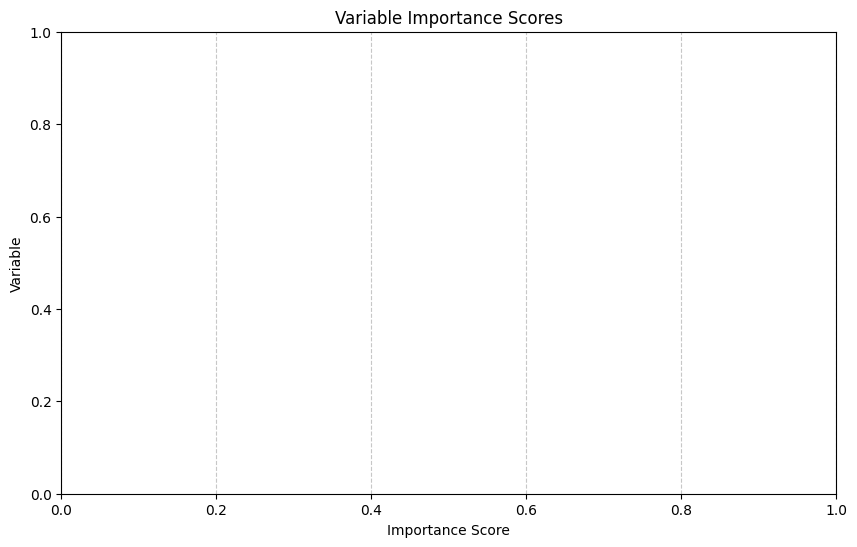

In [18]:
#Model training
importance_scores = functions.NP_model.get_importance_scores(basic, df_train, df_test, lr, test_start_date, forecast, future_regressor, added_events)

# Prepare data for plotting
variables = [var for var, score in importance_scores]
scores = [score for var, score in importance_scores]

# Create a DataFrame for seaborn
df_importance = pd.DataFrame({'Variable': variables, 'Importance Score': scores})

# Create a horizontal bar plot
fig = plt.figure(figsize=(10, 6))
sns.barplot(x='Importance Score', y='Variable', data=df_importance, palette='viridis')
plt.xlabel('Importance Score')
plt.ylabel('Variable')
plt.title('Variable Importance Scores')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
fig.savefig(f'{functions.settings.current_wd}/Proyectos/{functions.settings.project_name}/Output/Importance_Scores.png', dpi=fig.dpi)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():



 variable: Fondeo1dia
 variable: Cetes91
 variable: Cetes182
 variable: Cetes364
 variable: BonoM3
 variable: BonoM5
 variable: BonoM10
 variable: TasaFedEUA
 variable: Tbill1m
 variable: Tbill3m
 variable: Tbill6m
 variable: Tbill12m
 variable: Tnote3A
 variable: Tnote5A
 variable: Tnote10A
 variable: InflacionAn
 variable: MXNaUSD
 variable: Desempleo
 variable: IPC
 variable: SyP
 variable: ExpNoPetro
 variable: VIX_BMV
 variable: VIX_USA


WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Use

Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 19235.14it/s, loss=0.01, v_num=314, MAE_val=0.00161, RMSE_val=0.00204, Loss_val=0.0291, RegLoss_val=0.000, MAE=0.0012, RMSE=0.00147, Loss=0.0105, RegLoss=0.000]        


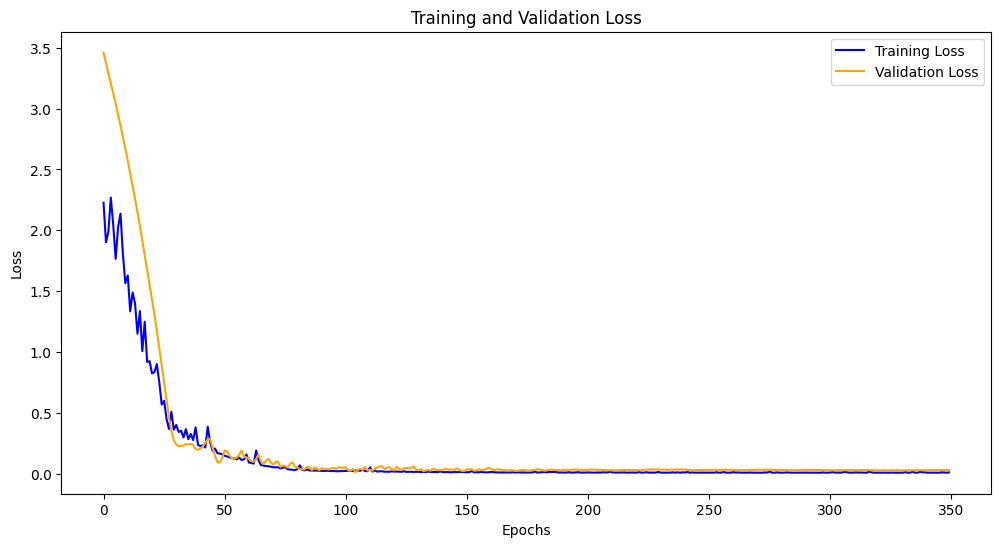

In [19]:

#Model training
m, metrics = functions.NP_model.train_model(df_train, df_test, lr, forecast, future_regressor, added_events)


# Create a larger figure
fig = plt.figure(figsize=(12, 6))
# Plot training loss curve
plt.plot(metrics['Loss'], label='Training Loss', color='blue')
# Plot validation loss curve
plt.plot(metrics['Loss_val'], label='Validation Loss', color='orange')
# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Show the plot
plt.show()
fig.savefig(f'{functions.settings.current_wd}/Proyectos/{functions.settings.project_name}/Output/Model_Loss.png', dpi=fig.dpi)


#m.plot_parameters().savefig('Model_Parameters.png')

In [20]:
for variable, result in granger_results.items():
    if variable in future_regressor:
        print(f"{variable}: Best Lag = {result['best_lag']}")

df_train_forecast=m.predict(df_train_f)
# Visualize the forecast
#m.plot(df_train_forecast)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternati

Fondeo1dia: Best Lag = 4
Cetes91: Best Lag = 9
Cetes182: Best Lag = 7
Cetes364: Best Lag = 9
BonoM3: Best Lag = 4
BonoM5: Best Lag = 4
BonoM10: Best Lag = 4
TasaFedEUA: Best Lag = 4
Tbill1m: Best Lag = 9
Tbill3m: Best Lag = 4
Tbill6m: Best Lag = 4
Tbill12m: Best Lag = 4
Tnote3A: Best Lag = 9
Tnote5A: Best Lag = 9
Tnote10A: Best Lag = 9
InflacionAn: Best Lag = 2
MXNaUSD: Best Lag = 9
Desempleo: Best Lag = 7
IPC: Best Lag = 7
SyP: Best Lag = 4
ExpNoPetro: Best Lag = 9
VIX_BMV: Best Lag = 9
VIX_USA: Best Lag = 5


WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``as

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 397.94it/s]


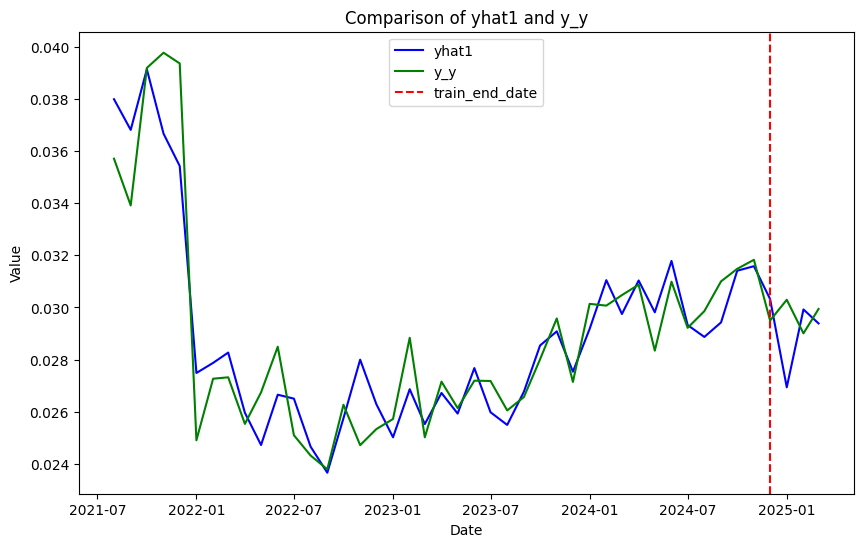

In [21]:
dd= df_train_forecast.merge(basic[['ds','y']], left_on='ds', right_on='ds', how='outer')
dd[['ds','y_y','yhat1']].tail(forecast+1)
# Extract 'ds', 'yhat1', and 'y_y' columns from the DataFrame
ds = dd['ds']
yhat1 = dd['yhat1']
y_y = dd['y_y']

# Plot the data
fig = plt.figure(figsize=(10, 6))
plt.plot(ds, yhat1, label='yhat1', color='blue')
plt.plot(ds, y_y, label='y_y', color='green')
plt.axvline(x=train_end_date, color='red', linestyle='--', label='train_end_date')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of yhat1 and y_y')
plt.legend()
plt.show()
fig.savefig(f'{functions.settings.current_wd}/Proyectos/{functions.settings.project_name}/Output/Comparacion_training.png', dpi=fig.dpi)

In [22]:
#Guardamos el modelo entrenado
functions.NP_model.save_model_attributes(forecast, lr)

#Guardamos los regresores
functions.NP_model.save_regressors('future_regressors', future_regressor)

#Guardamos los eventos
functions.NP_model.save_events('time_events', events)

El modelo se ha guardado correctamente
Los regresores seleccionados se han guardado correctamente
Los eventos ingresados se han guardado correctamente


## Inferencia

In [23]:
#Leemos los archivos guardados previamente para el proyecto
with open(f'{functions.settings.current_wd}/Proyectos/{functions.settings.project_name}/modelo_{functions.settings.project_name}.pkl', 'rb') as f:
    model_attributes = pickle.load(f)

with open(f'{functions.settings.current_wd}/Proyectos/{functions.settings.project_name}/future_regressors.pkl', 'rb') as f:
    future_regressor = pickle.load(f)

with open(f'{functions.settings.current_wd}/Proyectos/{functions.settings.project_name}/granger_results.pkl', 'rb') as f:
    significant_variables = pickle.load(f)

with open(f'{functions.settings.current_wd}/Proyectos/{functions.settings.project_name}/time_events.pkl', 'rb') as f:
    events = pickle.load(f)

### Seleccion de variables para el pronostico

In [24]:
significant_variables

['Fondeo1dia',
 'Cetes91',
 'Cetes182',
 'Cetes364',
 'BonoM3',
 'BonoM5',
 'BonoM10',
 'TasaFedEUA',
 'Tbill1m',
 'Tbill3m',
 'Tbill6m',
 'Tbill12m',
 'Tnote3A',
 'Tnote5A',
 'Tnote10A',
 'InflacionAn',
 'MXNaUSD',
 'Desempleo',
 'IPC',
 'SyP',
 'ExpNoPetro',
 'VIX_BMV',
 'VIX_USA']

#### Copiar los resultados de la celda anterior y comentar las variables que no se quieran incluir

In [25]:
future_regressor = [
    'Fondeo1dia',
    'Cetes91',
    'Cetes182',
    'Cetes364',
    'BonoM3',
    'BonoM5',
    'BonoM10',
    'TasaFedEUA',
    'Tbill1m',
    'Tbill3m',
    'Tbill6m',
    'Tbill12m',
    'Tnote3A',
    'Tnote5A',
    'Tnote10A',
    'InflacionAn',
    'MXNaUSD',
    'Desempleo',
    'IPC',
    'SyP',
    'ExpNoPetro',
    'VIX_BMV',
    'VIX_USA'
 ]

print("Regresores seleccionados:", future_regressor)

Regresores seleccionados: ['Fondeo1dia', 'Cetes91', 'Cetes182', 'Cetes364', 'BonoM3', 'BonoM5', 'BonoM10', 'TasaFedEUA', 'Tbill1m', 'Tbill3m', 'Tbill6m', 'Tbill12m', 'Tnote3A', 'Tnote5A', 'Tnote10A', 'InflacionAn', 'MXNaUSD', 'Desempleo', 'IPC', 'SyP', 'ExpNoPetro', 'VIX_BMV', 'VIX_USA']


In [26]:
basic=Bs_Hist[['ds','y']+ future_regressor]

added_events = []

for ev in events:
    df_event = pd.DataFrame(
            ev
        )
    event_name = df_event.columns[1]
    added_events.append(event_name)
    # Merge the 'covid' variable with your existing DataFrame
    basic = pd.merge(basic, df_event, on='ds', how='left')
    # Set 'covid' to 0 for dates outside the range
    basic[event_name] = basic[event_name].fillna(0)
    basic[basic[event_name]==1.0]


Esc_Base=VarsEco_Base.loc[VarsEco_Base['aniomes']>fecha_real,['aniomes']+future_regressor]
# Rename the selected columns
Esc_Base.rename(columns={'aniomes':'ds'},inplace=True)
Esc_Base['ds']=(Esc_Base['ds'].astype(str).str[0:4])+'-'+(Esc_Base['ds'].astype(str).str[4:6])+'-'+'01'
Esc_Base['ds']=pd.to_datetime(Esc_Base['ds'])
Esc_Base['y']=None
Esc_Base=Esc_Base[['ds','y']+ future_regressor]
df_base=pd.concat([basic,Esc_Base],ignore_index=True)
for event_name in added_events:
    df_base[event_name]=df_base[event_name].fillna(0)
#df_base.tail()


#print(basic.loc[basic['y']==basic['y'].max(),'ds'])
#print(basic.loc[basic['y']==basic['y'].min(),'ds'])

Esc_Adv=VarsEco_Adv.loc[VarsEco_Adv['aniomes']>fecha_real,['aniomes']+future_regressor]
# Rename the selected columns
Esc_Adv.rename(columns={'aniomes':'ds'},inplace=True)
Esc_Adv['ds']=(Esc_Adv['ds'].astype(str).str[0:4])+'-'+(Esc_Adv['ds'].astype(str).str[4:6])+'-'+'01'
Esc_Adv['ds']=pd.to_datetime(Esc_Adv['ds'])
Esc_Adv['y']=None
Esc_Adv=Esc_Adv[['ds','y']+ future_regressor]
df_adv=pd.concat([basic,Esc_Adv],ignore_index=True)
for event_name in added_events:
    df_adv[event_name]=df_adv[event_name].fillna(0)
#df_adv.tail()


forecast = len(Esc_Base)
print("Numero de predicciones: " + str(forecast))

WARNING - (py.warnings._showwarnmsg) - /var/folders/x_/p6ykz6vs43zcbk31gc41v4440000gp/T/ipykernel_7075/763587215.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_base=pd.concat([basic,Esc_Base],ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /var/folders/x_/p6ykz6vs43zcbk31gc41v4440000gp/T/ipykernel_7075/763587215.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_base=pd.concat([basic,Esc_Base],ignore_index=True)

WARNING - (py.warnings._showwarnmsg)

Numero de predicciones: 33


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select 

Epoch 340: 100%|██████████| 340/340 [00:00<00:00, 36449.84it/s, loss=0.0113, v_num=315, MAE=0.00116, RMSE=0.00142, Loss=0.0106, RegLoss=0.000]  


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternati

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 534.44it/s]


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternati

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 473.67it/s]


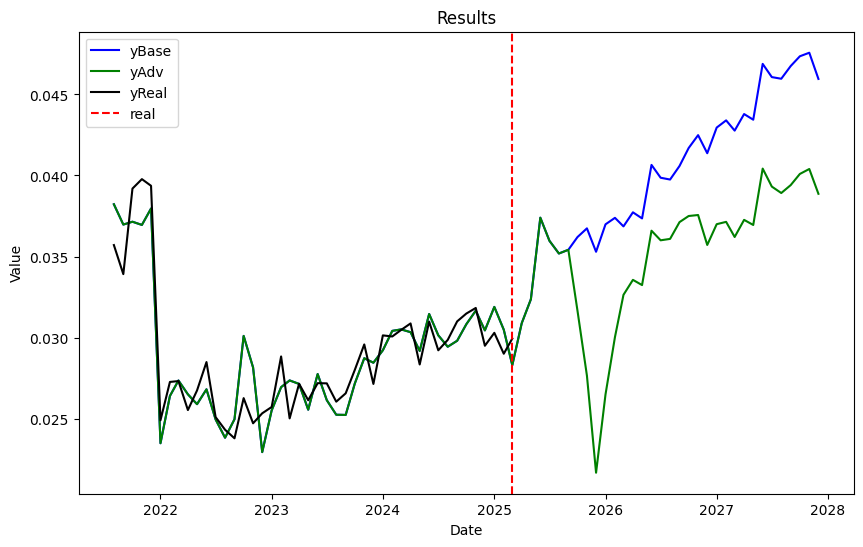

In [27]:
df_base_forecast, df_adv_forecast = functions.NP_model.run_model(model_attributes, future_regressor, basic, df_base, df_adv, added_events)

df_base_forecast.rename(columns={'yhat1':'y_Base'},inplace=True)
df_adv_forecast.rename(columns={'yhat1':'y_Adv'},inplace=True)

df_Estres= df_base_forecast.merge(df_adv_forecast[['ds','y_Adv']], left_on='ds', right_on='ds', how='outer')

# Extract 'ds', 'yhat1', and 'y_y' columns from the DataFrame
ds = df_Estres['ds']
yBase = df_Estres['y_Base']
yAdv = df_Estres['y_Adv']
yReal = df_Estres['y']

# Plot the data
fig = plt.figure(figsize=(10, 6))
plt.plot(ds, yBase, label='yBase', color='blue')
plt.plot(ds, yAdv, label='yAdv', color='green')
plt.plot(ds, yReal, label='yReal', color='black')
plt.axvline(x=basic.ds.max(), color='red', linestyle='--', label='real')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Results')
plt.legend()
plt.show()
fig.savefig(f'{functions.settings.current_wd}/Proyectos/{functions.settings.project_name}/Output/Forecast.png', dpi=fig.dpi)

In [28]:
resultados = df_Estres[['ds','y_Base','y_Adv']].iloc[-forecast:]
resultados.head()

,ds,y_Base,y_Adv
44,2025-04-01,0.030890,0.030890
45,2025-05-01,0.032365,0.032365
46,2025-06-01,0.037397,0.037397
47,2025-07-01,0.035970,0.035970
48,2025-08-01,0.035188,0.035188


### Guardado de resultados

In [29]:
resultados.to_csv(f'{functions.settings.current_wd}/Proyectos/{functions.settings.project_name}/Output/resultados.csv', index=False)
functions.NP_model.save_regressors('future_regressors', future_regressor)

Los regresores seleccionados se han guardado correctamente
